tests/5eddcb/smc/None/U20/2048/CRSMC/HMC.0.5.10.1.01f_p0.0.0.0078125.0.001.65536.0.9.a
log Z: 5.997, log E w: 5.979
Z    : 402.124, E w    : 395.062
ESS  : (1069.6 +- 43.1)/2048
476 torch.Size([4096, 1])
tensor([-8.7207, -8.9384, -6.7012, -7.4864, -8.7262], device='cuda:0')
ESS =  2128.8095703125

M =  476
tests/5eddcb/smc/None/U21/2048/CRSMC/HMC.0.5.10.1.01f_p0.0.0.0078125.0.001.65536.0.9.a
log Z: 6.402, log E w: 6.414
Z    : 603.186, E w    : 610.629
ESS  : (1529.4 +- 4.2)/2048
420 torch.Size([4096, 1])
tensor([-8.5226, -8.5366, -8.0438, -8.4519, -8.4030], device='cuda:0')
ESS =  3058.452880859375

M =  420
tests/5eddcb/smc/None/U22/2048/CRSMC/HMC.0.5.10.1.01f_p0.0.0.0078125.0.001.65536.0.9.a
log Z: 6.690, log E w: 6.437
Z    : 804.247, E w    : 624.505
ESS  : (1851.0 +- 2.0)/2048
378 torch.Size([4096, 1])
tensor([-8.1162, -7.6820, -8.4968, -8.7454, -8.0321], device='cuda:0')
ESS =  3701.948486328125

M =  378
tests/5eddcb/smc/None/U23/2048/CRSMC/HMC.0.5.10.1.01f_p0.0.0.0078125.0.001

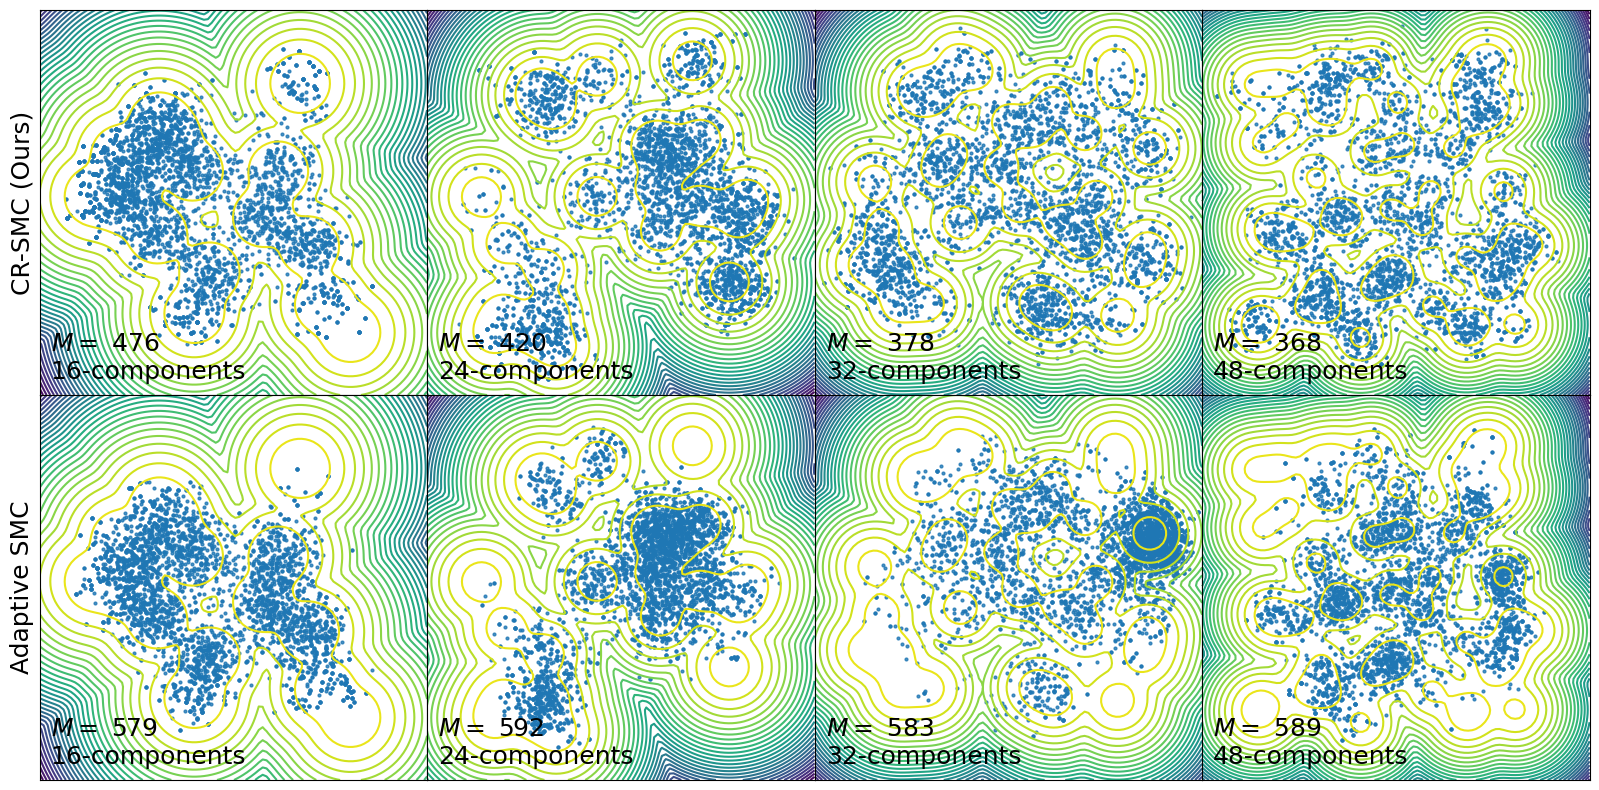

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, pickle

from utils.experiments import Default_ARGS as args
from utils.aux import get_ess, resample
from utils.targets import synthetic_targets
from utils.experiments import get_modified_experiment, get_dirs
from utils.plots import plot_energy_heatmap, plot_particles
from sampling.utils import get_sampler, estimate

args.testname="tests/5eddcb/smc"

## Target distribution
args.target='U20'
args.latent_dim=2
args.dataset=None
args.context_dim=0

## Sampling parameters
args.seed = 1
args.M=512
args.n_samples=2048
args.schedule='linear'
args.path='power'
args.annealing_alpha=0.
args.device=1
args.redo=False

## Transitions
args.transition='HMC'
args.transition_hidden_dim=4
args.transition_step_size=.5
args.transition_update = 'fixed'
args.transition_n_tune=1
args.hmc_partial_refresh = 10
args.hmc_alpha = 1.
args.hmc_n_leapfrogs = 1


args.min_step=0.0000001
args.max_step=1/512
args.ratio=0.9
args.conditional=True
args.dt = 1./128
args.max_M = 65536
args.tol = 1e-3
args.resampling = -1

args.redo = False

if args.target in ['U2', 'U3', 'U4']:
    LIMS = np.array([[-32, 32], [-4, 4]])
elif args.target in ['U20', 'U21', 'U22', 'U23']:
    LIMS = np.array([[-20, 20], [-20, 20]])
else:
    LIMS = np.array([[-4, 4], [-4, 4]])

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for s, sampler_kwargs in enumerate([
    {'sampler':'CRSMC'},
    {'sampler':'AdaptiveSMC', 'ratio':0.9},]):
    # {'sampler':'AdaptiveSMC', 'ratio':0.8},
    # {'sampler':'AdaptiveSMC', 'ratio':0.7},
    # {'sampler':'AdaptiveSMC', 'ratio':0.6},
    # {'sampler':'AdaptiveSMC', 'ratio':0.5},]):
    # {'sampler':'SMC', 'schedule':'linear'},
    # {'sampler':'SMC', 'schedule':'sigmoid'},
    # {'sampler':'SMC', 'schedule':'geometric'}]):
    sampler = sampler_kwargs['sampler']
    args.sampler = sampler
    if sampler == 'AdaptiveSMC':
        args.ratio = sampler_kwargs['ratio']
    elif sampler == 'SMC':
        args.schedule = sampler_kwargs['schedule']
        args.ratio = 0.9
    elif sampler == 'CRSMC':
        args.ratio = 0.9
    args, experiment, label = get_modified_experiment(args, args.sampler, config={
        'transition_step_size':args.transition_step_size,
        'transition_update':args.transition_update,
        'transition_n_tune':args.transition_n_tune,
        'hmc_partial_refresh': args.hmc_partial_refresh,
        'hmc_alpha': args.hmc_alpha,
        'hmc_n_leapfrogs': args.hmc_n_leapfrogs,
    })
    plot_x = None
    labels = ['16-components','24-components','32-components','48-components',]
    targets = ['U20', 'U21', 'U22', 'U23']
    i = 0
    for label, target in zip(labels, targets):
        target_log_density = synthetic_targets[target]
        target_log_density.cuda()
        plot_energy_heatmap(ax[s, i], target_log_density, x=None, lims=LIMS, contour=True, cmap='viridis')
        ax[s, i].set_xticks([])
        ax[s, i].set_yticks([])
        #ax[i // 4, int(i % 4) * 2].set_title(f'{label}', fontsize=18)

        args.target = target
        sampler, dirs = get_sampler(args, experiment, target_log_density, make_dirs=True)
        sampler.eval()
        print(dirs[0])

        if args.redo:
            z, log_w, transition_logs = sampler.sample(args.n_samples, plot_x, update_step_size=True, log=False)
            zs = transition_logs['z']
            log_ws = transition_logs['log_w']
            betas = torch.cat([torch.tensor([0.]).to(sampler.beta.device), sampler.beta], dim=0)

            sampler.tune_beta = False
            n_samples = args.n_samples
            z, log_w, transition_logs = sampler.sample(n_samples, plot_x, update_step_size=False, log=False)
            zs = transition_logs['z']
            log_ws = transition_logs['log_w']
            betas = torch.cat([torch.tensor([0.]).to(sampler.beta.device), sampler.beta], dim=0)

            transition_logs['beta'] = torch.cat([torch.tensor([0.]).to(sampler.beta.device), sampler.beta], dim=0)
            with open(os.path.join(dirs[-1], 'all.pkl'), 'wb+') as f:
                  pickle.dump({'eval_transitions':[transition_logs]}, f)
        else:
            with open(os.path.join(dirs[-1], 'all.pkl'), 'rb') as f:
                transition_logs = pickle.load(f)['eval_transitions'][0]
            n_samples = 4096
            betas = transition_logs['beta']
            sampler.beta_ = betas[1:]
            sampler.M = sampler.beta_.shape[0]
            zs = transition_logs['z'][:n_samples]
            log_ws = transition_logs['log_w'][:n_samples]
            
        estimate(transition_logs, target_log_density, n_samples=args.n_samples, prefix='', just_log=True)
        print(sampler.M, log_ws.shape)
        ess = get_ess(log_ws[:,-1]).item()
        print(log_ws[:5,-1])
        print('ESS = ', ess)
        plot_particles(ax[s,i], resample(zs[:,:,-1], log_ws[:,-1]), lims=LIMS, alpha=.8)
        label= r'$M = $ ' + f'{sampler.M}\n' + label
        ax[s,i].annotate(label, xy=(8, 8), xycoords='axes points',
            size=18, ha='left', va='bottom')
        ax[s,i].set_xticks([])
        ax[s,i].set_yticks([])
        # if s > 0:
        #     ax[s,0].set_ylabel(f'Adaptive SMC{args.ratio}', fontsize=18)
        print('M = ', sampler.M)
        #print(sampler.beta[-10:])
        #print(transition_logs['kde_var'][-10:])
        i += 1

ax[0,0].set_ylabel('CR-SMC (Ours)', fontsize=18)
ax[1,0].set_ylabel('Adaptive SMC', fontsize=18)
# ax[2,0].set_ylabel('Linear', fontsize=18)
# ax[3,0].set_ylabel('Sigmoid', fontsize=18)
# ax[4,0].set_ylabel('Exponential', fontsize=18)

os.makedirs(f'{args.testname}/plots', exist_ok=True)
plt.subplots_adjust(wspace=0., hspace=.0)
plt.savefig(f'{args.testname}/plots/particles_smc.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches = 0)

